In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import os
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

plt.rcParams['figure.figsize'] = (12, 6)
sns.set_style("whitegrid")

os.makedirs("model", exist_ok=True)

df = pd.read_csv("data/n_movies.csv")

print(f"Загружено фильмов: {len(df)}")
df.head()

Загружено фильмов: 9957


,title,year,certificate,duration,genre,rating,description,stars,votes
0,Cobra Kai,(2018– ),TV-14,30 min,"Action, Comedy, Drama",8.5,Decades after their 1984 All Valley Karate Tou...,"['Ralph Macchio, ', 'William Zabka, ', 'Courtn...","177,031"
1,The Crown,(2016– ),TV-MA,58 min,"Biography, Drama, History",8.7,Follows the political rivalries and romance of...,"['Claire Foy, ', 'Olivia Colman, ', 'Imelda St...","199,885"
2,Better Call Saul,(2015–2022),TV-MA,46 min,"Crime, Drama",8.9,The trials and tribulations of criminal lawyer...,"['Bob Odenkirk, ', 'Rhea Seehorn, ', 'Jonathan...","501,384"
3,Devil in Ohio,(2022),TV-MA,356 min,"Drama, Horror, Mystery",5.9,When a psychiatrist shelters a mysterious cult...,"['Emily Deschanel, ', 'Sam Jaeger, ', 'Gerardo...","9,773"
4,Cyberpunk: Edgerunners,(2022– ),TV-MA,24 min,"Animation, Action, Adventure",8.6,A Street Kid trying to survive in a technology...,"['Zach Aguilar, ', 'Kenichiro Ohashi, ', 'Emi ...","15,413"


In [4]:
print("Информация о датасете:")
print(df.info())

print("\nОсновные статистики:")
print(df.describe())

print("\nПропущенные значения:")
print(df.isnull().sum())

print("\nТоп-10 фильмов по рейтингу:")
print(df.nlargest(10, 'rating')[['title', 'year', 'rating', 'genre']])

Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9957 entries, 0 to 9956
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   title        9957 non-null   object 
 1   year         9430 non-null   object 
 2   certificate  6504 non-null   object 
 3   duration     7921 non-null   object 
 4   genre        9884 non-null   object 
 5   rating       8784 non-null   float64
 6   description  9957 non-null   object 
 7   stars        9957 non-null   object 
 8   votes        8784 non-null   object 
dtypes: float64(1), object(8)
memory usage: 700.2+ KB
None

Основные статистики:
            rating
count  8784.000000
mean      6.764515
std       1.214840
min       1.700000
25%       6.100000
50%       6.900000
75%       7.600000
max       9.900000

Пропущенные значения:
title             0
year            527
certificate    3453
duration       2036
genre            73
rating         1173
description   

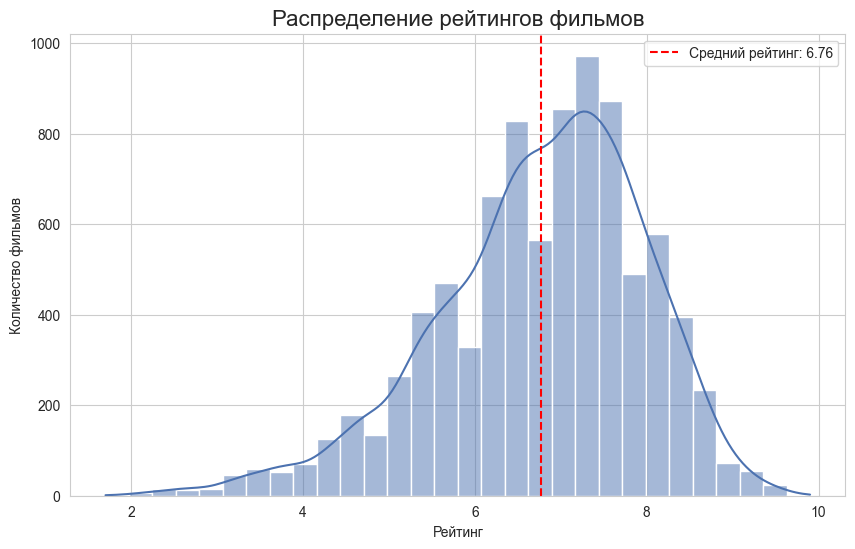

In [5]:
plt.figure(figsize=(10, 6))
sns.histplot(df['rating'], bins=30, kde=True, color='#4C72B0')
plt.title('Распределение рейтингов фильмов', fontsize=16)
plt.xlabel('Рейтинг')
plt.ylabel('Количество фильмов')
plt.axvline(df['rating'].mean(), color='red', linestyle='--', label=f"Средний рейтинг: {df['rating'].mean():.2f}")
plt.legend()
plt.show()

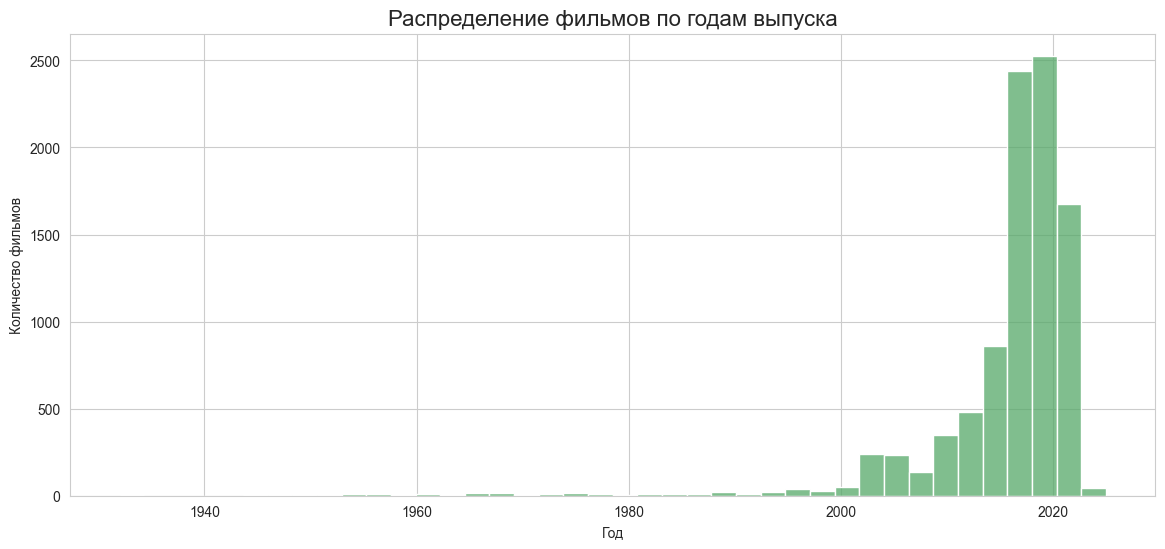

Самый старый фильм: 1932.0
Самый новый фильм: 2025.0


In [6]:
df['year_num'] = df['year'].str.extract(r'(\d{4})').astype(float)

plt.figure(figsize=(14, 6))
sns.histplot(df['year_num'].dropna(), bins=40, color='#55A868')
plt.title('Распределение фильмов по годам выпуска', fontsize=16)
plt.xlabel('Год')
plt.ylabel('Количество фильмов')
plt.show()

print(f"Самый старый фильм: {df['year_num'].min()}")
print(f"Самый новый фильм: {df['year_num'].max()}")

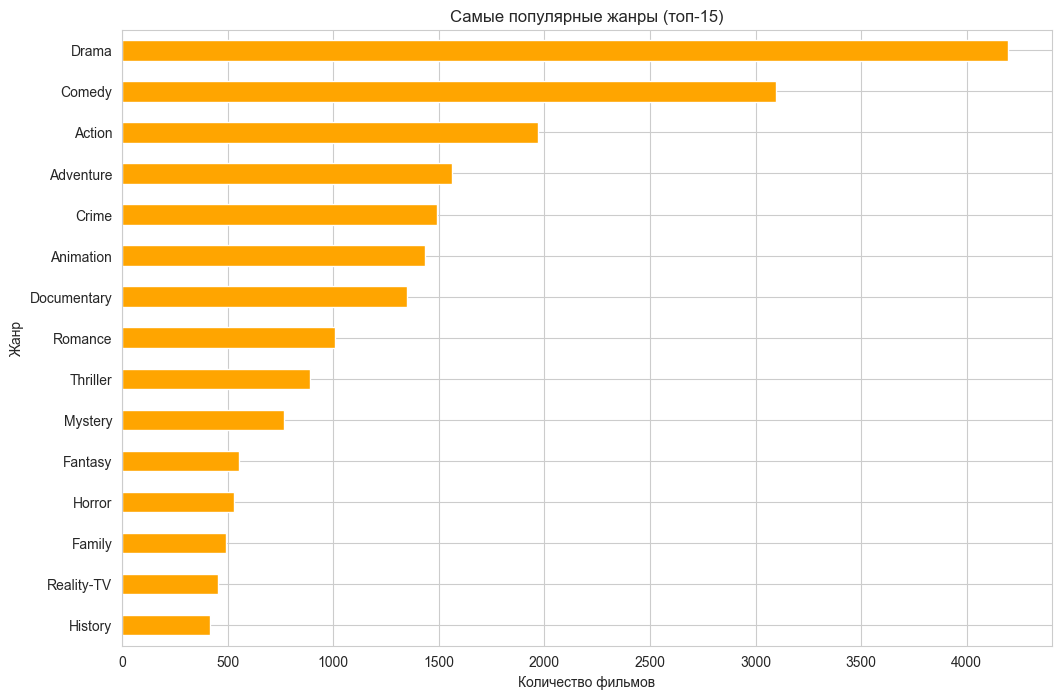

In [7]:
all_genres = df['genre'].str.split(', ').explode()
top_genres = all_genres.value_counts().head(15)

plt.figure(figsize=(12, 8))
top_genres.plot(kind='barh', color='orange')
plt.title('Самые популярные жанры (топ-15)')
plt.xlabel('Количество фильмов')
plt.ylabel('Жанр')
plt.gca().invert_yaxis() 
plt.show()

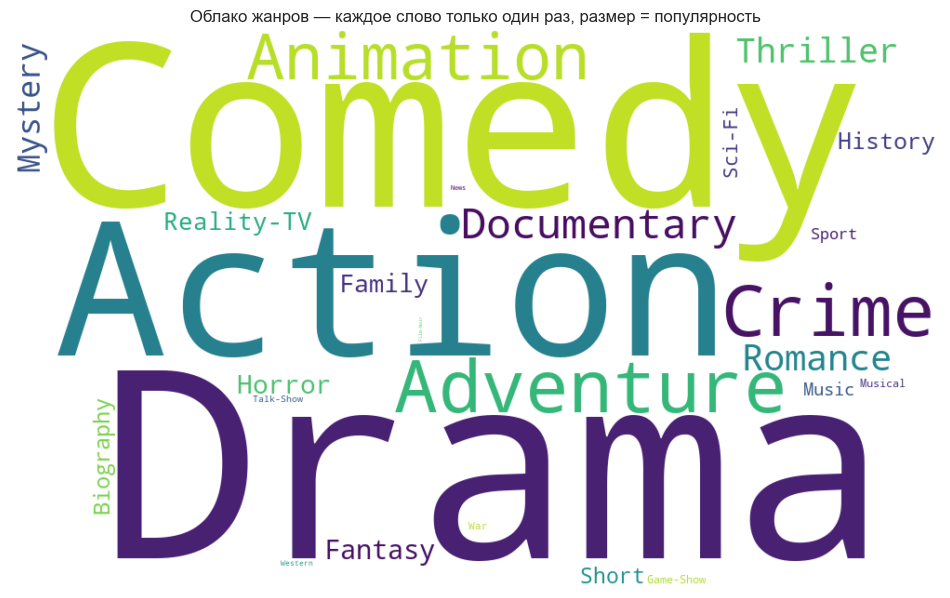

In [8]:
all_genres = df['genre'].str.split(', ').explode() 
genre_freq = all_genres.value_counts() 
text = " ".join(all_genres.dropna())

wordcloud = WordCloud(
    width=1000, height=600,
    background_color='white',
    colormap='viridis', 
    max_words=100,
    relative_scaling=0.5
).generate_from_frequencies(genre_freq) 

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Облако жанров — каждое слово только один раз, размер = популярность')
plt.show()

In [9]:
def rating_to_category(rating):
    if pd.isna(rating):
        return "unknown"
    rating = float(rating)
    if rating >= 9.0:
        return "excellent masterpiece"
    elif rating >= 8.0:
        return "very_good highly_rated"
    elif rating >= 7.0:
        return "good solid"
    elif rating >= 6.0:
        return "average ok"
    elif rating >= 5.0:
        return "mediocre poor"
    else:
        return "bad terrible"

In [10]:
df = df.drop_duplicates(subset="title").reset_index(drop=True)

df["genre"] = df["genre"].fillna("")
df["description"] = df["description"].fillna("")
df["stars_clean"] = (
    df["stars"]
    .str.replace(r'[\[\]\'\"]', '', regex=True) 
    .str.replace(r'\s*,\s*', ', ', regex=True)
    .str.replace(r',\s*,+', ',', regex=True)
    .str.strip(', ')
)

df["rating_category"] = df["rating"].apply(rating_to_category)

df["features"] = (
    df["genre"] + " " + df["genre"] + " " +
    df["genre"] + " " + df["genre"] + " " +
    df["stars_clean"] + " " + df["stars_clean"] +
    " " + df["description"].fillna("") + " " + df["rating_category"]
)

df["features"] = (
    df["features"]
    .str.replace(r'\s+', ' ', regex=True) 
    .str.strip()
    .str.lower()
)

print(f"После очистки осталось: {len(df)} фильмов")
df[["title", "features"]].head()

После очистки осталось: 7912 фильмов


,title,features
0,Cobra Kai,"action, comedy, drama action, comedy, drama ac..."
1,The Crown,"biography, drama, history biography, drama, hi..."
2,Better Call Saul,"crime, drama crime, drama crime, drama crime, ..."
3,Devil in Ohio,"drama, horror, mystery drama, horror, mystery ..."
4,Cyberpunk: Edgerunners,"animation, action, adventure animation, action..."


In [11]:
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df["features"])

similarity_matrix = cosine_similarity(tfidf_matrix)

print("Модель готова!")
print(f"Матрица сходства: {similarity_matrix.shape}")

Модель готова!
Матрица сходства: (7912, 7912)


In [12]:
np.save("model/similarity_matrix.npy", similarity_matrix)
pickle.dump(df["title"].tolist(), open("model/titles.pkl", "wb"))
pickle.dump(vectorizer, open("model/vectorizer.pkl", "wb"))
df.to_pickle("model/movies_data.pkl")

print("Всё сохранено в папку model!")

Всё сохранено в папку model!


In [13]:
def test_recommend(title):
    if title not in df["title"].values:
        print(f"Фильм '{title}' не найден")
        return
    idx = df[df["title"] == title].index[0]
    scores = similarity_matrix[idx]
    top_idx = scores.argsort()[-7:-1][::-1]
    print(f"\nРекомендации для: {title}")
    print(df.iloc[top_idx][["title", "year", "rating"]].to_string(index=False))

test_recommend("Cobra Kai")
test_recommend("Breaking Bad")


Рекомендации для: Cobra Kai
                                    title year  rating
     Untitled Spenser Confidential Sequel  NaN     NaN
      Untitled Scott Pilgrim anime series  NaN     NaN
                                  The F-U  NaN     NaN
  The Kane Chronicles: The Throne of Fire  NaN     NaN
The Kane Chronicles: The Serpent's Shadow  NaN     NaN
     The Kane Chronicles: The Red Pyramid  NaN     NaN

Рекомендации для: Breaking Bad
                        title   year  rating
                  The Craving    NaN     NaN
                     Qucksand    NaN     NaN
Untitled Sean O'Keefe Project    NaN     NaN
                        Again    NaN     NaN
              The Infiltrator (2016)     7.0
                     Triple 9 (2016)     6.3


In [14]:
print("Статистика сходства рекомендаций:")
similarities_top5 = []
for i in range(len(df)):
    scores = list(enumerate(similarity_matrix[i]))
    scores = sorted(scores, key=lambda x: x[1], reverse=True)[1:6]
    similarities_top5.extend([score for _, score in scores])

print(f"Среднее сходство рекомендаций: {np.mean(similarities_top5):.3f}")
print(f"Медианное сходство: {np.median(similarities_top5):.3f}")
print(f"Минимальное сходство: {np.min(similarities_top5):.3f}")
print(f"Максимальное сходство: {np.max(similarities_top5):.3f}")
print(f"Стандартное отклонение: {np.std(similarities_top5):.3f}")

Статистика сходства рекомендаций:
Среднее сходство рекомендаций: 0.265
Медианное сходство: 0.233
Минимальное сходство: 0.063
Максимальное сходство: 1.000
Стандартное отклонение: 0.123


In [15]:
print("Покрытие каталога:")

def calculate_coverage(similarity_matrix, k=5):
    recommended_counts = np.zeros(len(df))
    
    for i in range(len(df)):
        top_indices = np.argsort(similarity_matrix[i])[::-1][1:k+1]
        recommended_counts[top_indices] += 1
    
    coverage = np.sum(recommended_counts > 0) / len(df)
    never_recommended = np.sum(recommended_counts == 0)
    most_recommended = np.max(recommended_counts)
    avg_recommendations = np.mean(recommended_counts[recommended_counts > 0])
    
    return coverage, never_recommended, most_recommended, avg_recommendations

coverage, never_rec, most_rec, avg_rec = calculate_coverage(similarity_matrix, k=5)
print(f"   Покрытие каталога: {coverage:.1%} ({coverage*len(df):.0f}/{len(df)} фильмов)")
print(f"   Никогда не рекомендованы: {never_rec} фильмов")
print(f"   Максимум рекомендаций у одного фильма: {most_rec}")
print(f"   Среднее рекомендаций на фильм: {avg_rec:.1f}")

Покрытие каталога:
   Покрытие каталога: 77.0% (6094/7912 фильмов)
   Никогда не рекомендованы: 1818 фильмов
   Максимум рекомендаций у одного фильма: 577.0
   Среднее рекомендаций на фильм: 6.5


In [16]:
print("Разнообразие рекомендаций:")

def calculate_diversity(similarity_matrix, k=5):
    diversities = []
    
    for i in range(len(df)):
        top_indices = np.argsort(similarity_matrix[i])[::-1][1:k+1]
        
        if len(top_indices) > 1:
            sub_matrix = similarity_matrix[top_indices][:, top_indices]
            np.fill_diagonal(sub_matrix, 0)
            avg_similarity = sub_matrix.sum() / (len(top_indices) * (len(top_indices) - 1))
            diversity = 1 - avg_similarity
            diversities.append(diversity)
    
    return np.mean(diversities) if diversities else 0

diversity_score = calculate_diversity(similarity_matrix, k=5)
print(f"   Оценка разнообразия: {diversity_score:.3f}")

Разнообразие рекомендаций:
   Оценка разнообразия: 0.646


In [19]:
import random
random.seed(42)
random_films = random.sample(list(df["title"]), 100)
total_precision = 0
total_recall = 0
total_f1 = 0
count = 0

for film in random_films:
    idx = df[df["title"] == film].index[0]
    scores = similarity_matrix[idx]

    top3_idx = scores.argsort()[-4:-1][::-1] 
    
    print(f"Для '{film}':")
    main_genres = set(str(df.iloc[idx]['genre']).split(', '))
    good_count = 0
    for i, rec_idx in enumerate(top3_idx, 1):
        rec = df.iloc[rec_idx]
        similarity = scores[rec_idx]
        rec_genres = set(str(rec['genre']).split(', '))
        common_genres = main_genres & rec_genres
        if common_genres:
            mark = "+"
            good_count += 1
        else:
            mark = "-"
        
        print(f"   {mark} {i}. {rec['title']} (сходство: {similarity:.2f})")
        if common_genres:
            print(f"       Общие жанры: {', '.join(common_genres)}")

    precision = good_count / 3
    recall = 1 if good_count > 2 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    
    total_precision += precision
    total_recall += recall
    total_f1 += f1_score
    count += 1
    
    print(f"   ---")
    print(f"   Precision для этого фильма: {precision:.2f} ({good_count}/3 хороших)")
    print(f"   Recall для этого фильма: {recall:.2f}")
    print(f"   F1 Score для этого фильма: {f1_score:.2f}")

if count > 0:
    avg_precision = total_precision / count
    avg_recall = total_recall / count
    avg_f1 = total_f1 / count

    print(f"ИТОГО по {count} фильмам:")
    print(f"   Средний Precision: {avg_precision:.2f}")
    print(f"   Средний Recall: {avg_recall:.2f}")
    print(f"   Средний F1 Score: {avg_f1:.2f}")

Для 'Moh Maya Money':
   + 1. Hasmukh (сходство: 0.22)
       Общие жанры: Drama, Crime
   + 2. The Craving (сходство: 0.18)
       Общие жанры: Thriller
   + 3. Qucksand (сходство: 0.18)
       Общие жанры: Thriller
   ---
   Precision для этого фильма: 1.00 (3/3 хороших)
   Recall для этого фильма: 1.00
   F1 Score для этого фильма: 1.00
Для 'The Dark Crystal: Age of Resistance':
   + 1. Mermaid Magic (сходство: 0.24)
       Общие жанры: Adventure, Family
   + 2. The BFG (сходство: 0.24)
       Общие жанры: Adventure, Family
   + 3. Robin Hood (сходство: 0.22)
       Общие жанры: Drama, Adventure
   ---
   Precision для этого фильма: 1.00 (3/3 хороших)
   Recall для этого фильма: 1.00
   F1 Score для этого фильма: 1.00
Для 'The Anthrax Attacks':
   - 1. The Old Ways (сходство: 0.21)
   + 2. Wounded: The Battle Back Home (сходство: 0.19)
       Общие жанры: Documentary
   + 3. Road to Victory - Okinawa (сходство: 0.19)
       Общие жанры: Documentary
   ---
   Precision для этого филь

Поскольку у данного датасета есть ключевая особенность - слабая "схожесть" фильмов, то получить "идеальный" результат очень-очень трудно. В данной можели Precision и Recall гармонично дополняют друг друга, что означает, что модель выбирает ПРАВИЛЬНЫЕ фильмы. Покрытие 77% означает, что выбирается большая часть фильмов - то есть достаточно малая часть остается ВООБЩЕ без внимания. Рекомендации достаточно разнообразны. Ну и схожесть удовлетворительная с учётом особенности датасета.

Нами было решено остановиться именно на этой модели поскольку она простая, понятная и не требует сложных вычислений / огромного количества данных.